In [3]:
# Set path to the parent directory
import sys
sys.path.append('../') # let you import from parent directory

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from tqdm import tqdm
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Import .py files and their functions
from bbox import rot, get_bbox
from utils import save_images, write_paths, write_labels, write_rotation_vectors, \
                    write_centroids, write_sizes, write_clouds, write_camera_matrices

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


class, Type, Label:
[['0' 'Unknown' '0']
 ['1' 'Compacts' '1']
 ['2' 'Sedans' '1']
 ['3' 'SUVs' '1']
 ['4' 'Coupes' '1']
 ['5' 'Muscle' '1']
 ['6' 'SportsClassics' '1']
 ['7' 'Sports' '1']
 ['8' 'Super' '1']
 ['9' 'Motorcycles' '2']
 ['10' 'OffRoad' '2']
 ['11' 'Industrial' '2']
 ['12' 'Utility' '2']
 ['13' 'Vans' '2']
 ['14' 'Cycles' '2']
 ['15' 'Boats' '0']
 ['16' 'Helicopters' '0']
 ['17' 'Planes' '0']
 ['18' 'Service' '0']
 ['19' 'Emergency' '0']
 ['20' 'Military' '0']
 ['21' 'Commercial' '0']
 ['22' 'Trains' '0']]

labels: [0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0]


## Training Data
- Scene Snapshots
- Bounding Boxes
  - Labels of Bounding Boxes
  - Rotation Vectors
  - Centroids (x, y, z)
  - Size of Bounding Box (Length, Width, Height)
- Point Clouds
- Camera Matrices

In [2]:
# Collect and save labels, centroids, point clouds, and camera matrices data
path = 'trainval' # path to folder containing training snapshots, bbox.bin, cloud.bin, proj.bin

# Test Images
if not os.path.exists('./test/test_images.npy'):
    save_images('test') # trainval_paths.npy

# File Paths
if not os.path.exists('./trainval/trainval_paths.npy'):
    write_paths(path) # trainval_paths.npy

if not os.path.exists('./test/test_paths.npy'):
    write_paths('test') # test_paths.npy

# Labels of Bounding Boxes
if not os.path.exists('./trainval/trainval_labels.npy'):
    write_labels(path) # trainval_labels.npy

# Bounding Box Features - Rotation Vectors
if not os.path.exists('./trainval/trainval_rotation_vectors.npy'):
    write_rotation_vectors(path) # trainval_rotations.npy

# Bounding Box Features - Centroids
if not os.path.exists('./trainval/trainval_centroids.npy'):
    write_centroids(path) # trainval_centroids.npy

# Bounding Box Features - Sizes
if not os.path.exists('./trainval/trainval_sizes.npy'):
    write_sizes(path) # trainval_sizes.npy

# Point Clouds
if not os.path.exists('./trainval/trainval_pointclouds.npy'):
    write_clouds(path) # trainval_pointclouds.npy

# Camera Matrices
if not os.path.exists('./trainval/trainval_camera_matrices.npy'):
    write_camera_matrices(path) # trainval_camera_matrices.npy

## Demo

trainval\c6b38078-47e9-41e4-913a-c082736fb1cf\0141_image.jpg


C:\Users\whdqk\AppData\Local\Temp\ipykernel_49956\63313881.py:44: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax2 = Axes3D(fig2)


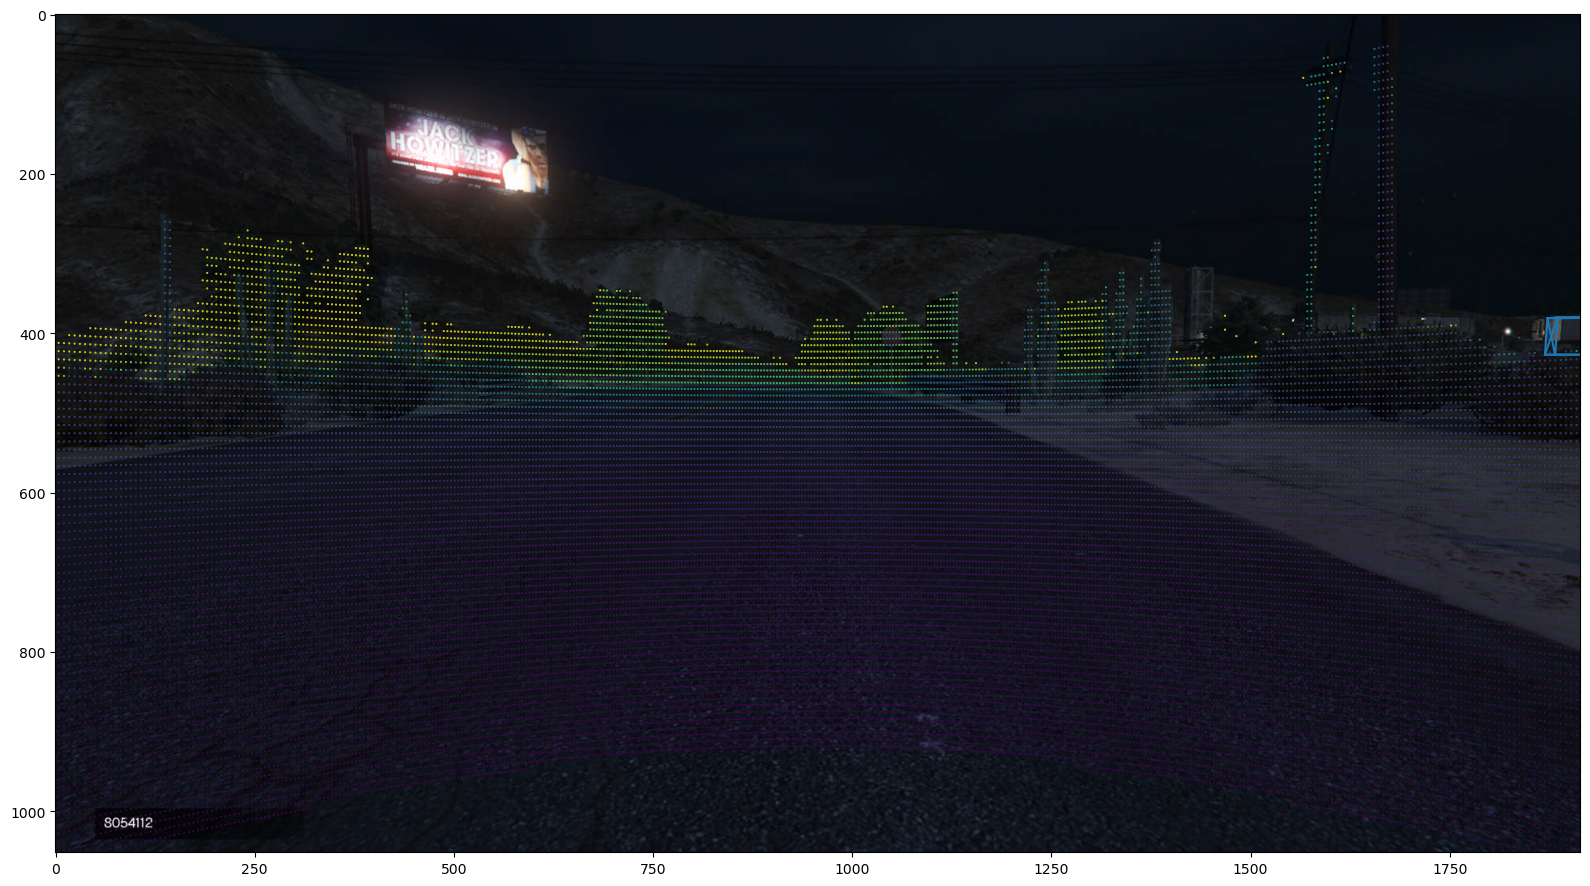

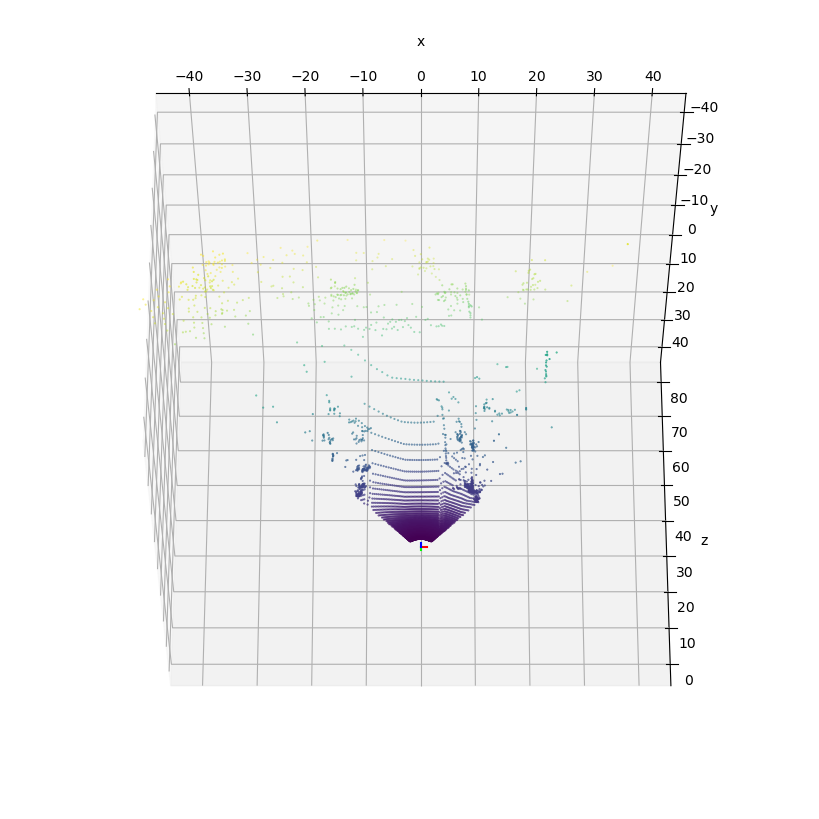

In [6]:
classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)

files = glob('trainval/*/*_image.jpg')
# for idx in range(len(files)):
idx = np.random.randint(0, len(files))
idx = 6090
snapshot = files[idx]
print(snapshot)

img = plt.imread(snapshot)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
except FileNotFoundError:
    print('[*] bbox not found.')
    bbox = np.array([], dtype=np.float32)

bbox = bbox.reshape([-1, 11])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)
fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)
ax1.axis('scaled')
fig1.tight_layout()

fig2 = plt.figure(2, figsize=(8, 8))
ax2 = Axes3D(fig2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

step = 5
ax2.scatter(
    xyz[0, ::step], xyz[1, ::step], xyz[2, ::step],
    c=dist[::step], marker='.', s=1
)

colors = ['C{:d}'.format(i) for i in range(10)]
for k, b in enumerate(bbox):
    R = rot(b[0:3])
    t = b[3:6]

    sz = b[6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)

    vert_3D = R @ vert_3D + t[:, np.newaxis]

    # vert_3D[0,:] = -vert_3D[0,:] # this is for horizontal flipping

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]

    clr = colors[np.mod(k, len(colors))]
    for e in edges.T:
        ax1.plot(vert_2D[0, e], vert_2D[1, e], color=clr)
        ax2.plot(vert_3D[0, e], vert_3D[1, e], vert_3D[2, e], color=clr)

    c = classes[int(b[9])]
    ignore_in_eval = bool(b[10])
    if ignore_in_eval:
        ax2.text(t[0], t[1], t[2], c, color='r')
    else:
        ax2.text(t[0], t[1], t[2], c)

ax2.auto_scale_xyz([-40, 40], [-40, 40], [0, 80])
ax2.view_init(elev=-30, azim=-90)

for e in np.identity(3):
    ax2.plot([0, e[0]], [0, e[1]], [0, e[2]], color=e)

plt.show()

## Data Preprocessing

### Snapshot (Image) Data

In [1]:
# Snapshots
train_snapshots = glob('trainval/*/*_image.jpg') # Grab all the snapshots
test_snapshots = glob('test/*/*_image.jpg') # Grab all the snapshots

NameError: name 'glob' is not defined

Sample snapshot size: (1914, 1052)


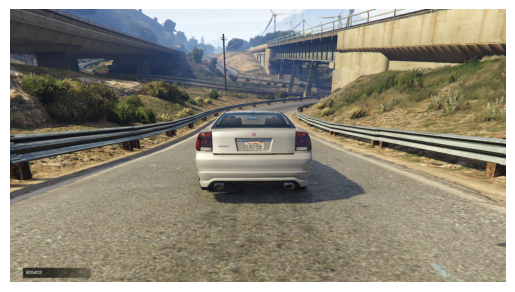

In [5]:
# Sample snapshot
np.random.seed(999) # random seed for reproducibility
sample_idx = np.random.randint(0, len(train_snapshots)) # random index
sample_snapshot = train_snapshots[sample_idx] # sample snapshot file path
# sample_snapshot = plt.imread(sample_snapshot) # sample snapshot image array
sample_snapshot = Image.open(sample_snapshot) # sample snapshot image array
print('Sample snapshot size: {}'.format(sample_snapshot.size))
plt.imshow(sample_snapshot)
plt.axis('off')
plt.show()

### Labels & Feature Variables
- Scene Snapshots
- Bounding Boxes
  - Labels of Bounding Boxes
  - Rotation Vectors
  - Centroids (x, y, z)
  - Size of Bounding Box (Length, Width, Height)
- Point Clouds
- Camera Matrices

### Load Data

In [6]:
# Root directory for training data
train_root = './trainval/'
test_root = './test/'

# Load data
train_paths = np.load(train_root + 'trainval_paths.npy') # each training data's path (for reference)
test_paths = np.load(test_root + 'test_paths.npy') # each test data's path (for reference)
labels = np.load(train_root + 'trainval_labels.npy')
rotation_vectors = np.load(train_root + 'trainval_rotation_vectors.npy')
centroids = np.load(train_root + 'trainval_centroids.npy')
sizes = np.load(train_root + 'trainval_sizes.npy')
point_clouds = np.load(train_root + 'trainval_pointclouds.npy', allow_pickle=True)
camera_matrices = np.load(train_root + 'trainval_camera_matrices.npy', allow_pickle=True)

### Custom Dataset
- **Our CustomDataset can handle horizontal flipping of the bounding box accordingly as the snapshot image is horizontally flipped.**
- **Our CustomDataset can handle resizing of the bounding box accordingly as the snapshot image is resized.**

In [7]:
class CustomDataset(Dataset):
    def __init__(self, snapshots, labels=None, rotation_vectors=None, 
                 centroids=None, sizes=None, camera_matrices=None, point_clouds=None,
                 flip_transform=None, norm_transform=None, resize_transform=None,
                 paths=None,
                 task='train'):
            
        self.task = task # task type

        if self.task == 'test':
            self.snapshots = snapshots # snapshot image
            self.paths = paths # each data's path (for reference)
        
        elif self.task == 'train':
            self.flip_transform = flip_transform # data augmentation
            self.norm_transform = norm_transform # data normalization
            self.resize_transform = resize_transform # data resizing
            
            self.snapshots = snapshots # snapshot images
            self.labels = labels # bounding boxes' labels
            self.rotation_vectors = rotation_vectors # bounding boxes' rotation vectors
            self.centroids = centroids # bounding boxes' centroids
            self.sizes = sizes # bounding boxes' sizes
            self.camera_matrices = camera_matrices # camera matrices
            self.point_clouds = point_clouds # point clouds
    
    def __len__(self):
        return len(self.snapshots)
    
    def __getitem__(self, idx):
        if self.task == 'test':
            snapshot = Image.open(self.snapshots[idx]) # snapshot image
            snapshot = transforms.ToTensor()(snapshot) # convert to tensor
            path = self.paths[idx] # each data's path (for reference)
            return snapshot, path

        elif self.task == 'train':
            snapshot = Image.open(self.snapshots[idx])
            snapshot = transforms.ToTensor()(snapshot) # convert to tensor

            if self.resize_transform is not None:
                original_height, original_width = snapshot.shape[1], snapshot.shape[2] # original image size
                snapshot = self.resize_transform(snapshot) # resizing
                new_height, new_width = snapshot.shape[1], snapshot.shape[2] # new image size
                height_scale = new_height / original_height # height scaling factor
                width_scale = new_width / original_width # width scaling factor
            
            # if self.norm_transform is not None:
            #     snapshot = self.norm_transform(snapshot) # normalization

            label = self.labels[idx] # label (vehicle type)
            rotation_vector = self.rotation_vectors[idx] # rotation vector (for 3D bounding box)
            centroid = self.centroids[idx] # centroid (for 3D bounding box)
            size = self.sizes[idx] # size (for 3D bounding box)
            camera_matrix = self.camera_matrices[idx] # camera matrix (for 3D bounding box)
            
            # If there is a flip transform method applied
            if self.flip_transform is not None:
                snapshot, bbox_coords = self.flip_transform(snapshot, rotation_vector, 
                                                            centroid, size, camera_matrix)
                
                # If there is a resize transform method applied
                if self.resize_transform is not None:
                    bbox_coords[:,[0,1]] *= width_scale # scale x coordinates (x_min, x_max)
                    bbox_coords[:,[2,3]] *= height_scale # scale y coordinates (y_min, y_max)

            # Else
            else:
                proj = camera_matrix
                
                R = rot(rotation_vector)
                t = centroid
                sz = size

                vert_3D, edges = get_bbox(-sz / 2, sz / 2)

                vert_3D = R @ vert_3D + t[:, np.newaxis]

                vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
                vert_2D = vert_2D / vert_2D[2, :]

                x_array = []
                y_array = []
                for e in edges.T:
                    x_array.append(vert_2D[0, e])
                    y_array.append(vert_2D[1, e])
                x_array = torch.tensor(x_array)
                y_array = torch.tensor(y_array)
                bbox_coords = torch.cat([x_array, y_array], dim=1) # [x_min, x_max, y_min, y_max]

                # If there is a resize transform method applied
                if self.resize_transform is not None:
                    bbox_coords[:,[0,1]] *= width_scale # scale x coordinates (x_min, x_max)
                    bbox_coords[:,[2,3]] *= height_scale # scale y coordinates (y_min, y_max)

            return snapshot, bbox_coords, label


### Custom Collate Function to Handle Variable-size Input

In [8]:
# A point cloud set for each snapshot image has a different number of points.
# Collate function is for handling variable-size input when batch size > 1
def custom_collate(batch):
    batch_size = len(batch)
    snapshots, labels, rotation_vectors, centroids, sizes, camera_matrices, point_clouds = zip(*batch)

    # Ensure all point clouds have a consistent shape
    reshaped_point_clouds = [pc.reshape(-1, 1) if pc.ndim == 1 else pc for pc in point_clouds]

    max_point_cloud_length = max([len(pc) for pc in reshaped_point_clouds])
    padded_point_clouds = []
    masks = []
    
    for pc in reshaped_point_clouds:
        pad_length = max_point_cloud_length - len(pc)
        padded_pc = np.pad(pc, ((0, pad_length), (0, 0)))
        padded_point_clouds.append(padded_pc)

        # Create a binary mask for the point cloud
        mask = np.zeros(max_point_cloud_length)
        mask[:len(pc)] = 1
        masks.append(mask)
    
    snapshots = torch.tensor(np.stack(snapshots))
    labels = torch.tensor(labels)
    rotation_vectors = torch.tensor(rotation_vectors)
    centroids = torch.tensor(centroids)
    sizes = torch.tensor(sizes)
    camera_matrices = torch.tensor(camera_matrices)
    point_clouds = torch.tensor(padded_point_clouds)
    masks = torch.tensor(masks) # binary mask for variable-size point clouds since they are padded
                                # 1: valid point
                                # 0: padded point
                                # this can be used during neural network training to ignore padded points
    
    return snapshots, labels, rotation_vectors, centroids, sizes, camera_matrices, point_clouds, masks


### Custom Data Augmentation Techniques

In [9]:
# Custom horizontal flip transform
class CustomHorizontalFlip(transforms.RandomHorizontalFlip):
    def __init__(self, p=0.5):
        super(CustomHorizontalFlip, self).__init__()
        self.p = p

    def __call__(self, snapshot, rotation_vector, centroid, size, camera_matrix):
        if random.random() < self.p:
            # Horizontal flip snapshot image
            transformed_snapshot = transforms.functional.hflip(snapshot)

            # Horizontal flip 3D bounding box projected on the 2D image plane
            proj = camera_matrix
            
            R = rot(rotation_vector)
            t = centroid
            sz = size

            vert_3D, edges = get_bbox(-sz / 2, sz / 2)

            vert_3D = R @ vert_3D + t[:, np.newaxis]

            vert_3D[0,:] = -vert_3D[0,:] # this is for horizontal flipping

            vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
            vert_2D = vert_2D / vert_2D[2, :]

            x_array = []
            y_array = []
            for e in edges.T:
                x_array.append(vert_2D[0, e])
                y_array.append(vert_2D[1, e])
            x_array = torch.tensor(x_array) 
            y_array = torch.tensor(y_array)
            bbox_coords = torch.cat([x_array, y_array], dim=1) # [x_min, x_max, y_min, y_max]

            return transformed_snapshot, bbox_coords
        
        else:
            proj = camera_matrix
                
            R = rot(rotation_vector)
            t = centroid
            sz = size

            vert_3D, edges = get_bbox(-sz / 2, sz / 2)

            vert_3D = R @ vert_3D + t[:, np.newaxis]

            vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
            vert_2D = vert_2D / vert_2D[2, :]

            x_array = []
            y_array = []
            for e in edges.T:
                x_array.append(vert_2D[0, e])
                y_array.append(vert_2D[1, e])
            x_array = torch.tensor(x_array)
            y_array = torch.tensor(y_array)
            bbox_coords = torch.cat([x_array, y_array], dim=1) # [x_min, x_max, y_min, y_max]

            return snapshot, bbox_coords


# Image flip
flip_transform = CustomHorizontalFlip(p=0.5)


# Image normalization
norm_transform = transforms.Compose([
                    # Normalize with mean and standard deviation from ImageNet pretrained model
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

# Image resize
resize_transform = transforms.Compose([
                    transforms.Resize((224, 224))
                    ])

### Dataset & DataLoader

In [10]:
# Dataset
trainval_dataset = CustomDataset(train_snapshots, labels=labels, rotation_vectors=rotation_vectors, 
                        centroids=centroids, sizes=sizes, camera_matrices=camera_matrices, 
                        flip_transform=flip_transform, norm_transform=norm_transform,
                        resize_transform=resize_transform,
                        task='train')

test_dataset = CustomDataset(test_snapshots, paths=test_paths, task='test')

# Train Val Split
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# Batch size
train_batch_size = 32
val_batch_size = 32
test_batch_size = 1

# Dataloader
train_dataloader = DataLoader(train_dataset, 
                            batch_size=train_batch_size, 
                            shuffle=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=val_batch_size,
                            shuffle=True)
test_dataloader = DataLoader(test_dataset,
                            batch_size=test_batch_size,
                            shuffle=False)

### A Sample Batch of Data From Dataloader

C:\Users\whdqk\AppData\Local\Temp\ipykernel_48496\3849703497.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  x_array = torch.tensor(x_array)


tensor([[193.0117, 186.4417,  88.3972,  84.3082],
        [193.0530, 186.4065,  84.3818,  88.3308],
        [193.6731, 193.7185,  88.3514,  84.0098],
        [193.6731, 193.0117,  88.3514,  88.3972],
        [193.0530, 193.7185,  84.3818,  84.0098],
        [193.0530, 193.0117,  84.3818,  88.3972],
        [193.6731, 186.5322,  88.3514,  88.2795],
        [193.7185, 186.5704,  84.0098,  83.9294],
        [193.0117, 186.4065,  88.3972,  88.3308],
        [193.0530, 186.4417,  84.3818,  84.3082],
        [186.5322, 186.5704,  88.2795,  83.9294],
        [186.5322, 186.4065,  88.2795,  88.3308],
        [186.4417, 186.5704,  84.3082,  83.9294],
        [186.4417, 186.4065,  84.3082,  88.3308]], dtype=torch.float64)
tensor(1, dtype=torch.uint8)


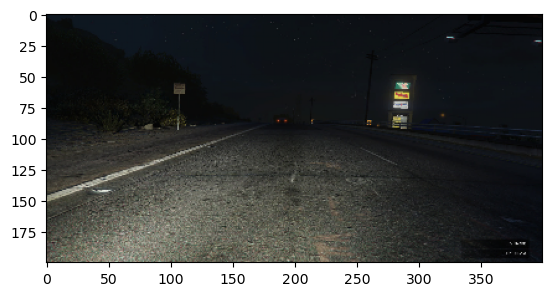

In [11]:
# Sampled random batch of data
data = next(iter(train_dataloader))

# Sampled snapshot
plt.imshow(data[0][0].numpy().transpose(1,2,0)) # C H W --> H W C

# Bounding box coordinates
print(data[1][0]) # [x_min, x_max, y_min, y_max]

# Label
print(data[2][0]) # label (0, 1, or 2 --> classifying vehicle type)

### Sampled Bounding Box

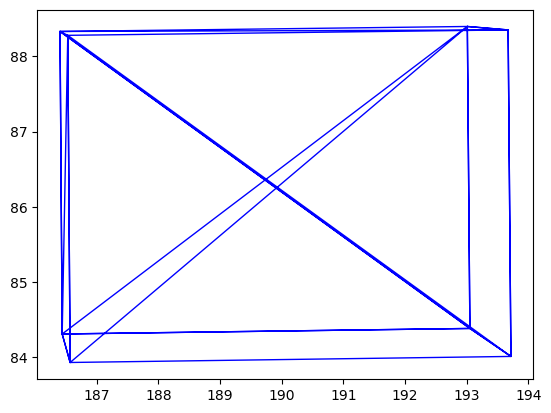

In [12]:
bbox_sample = data[1][0]
bbox_x_sample = bbox_sample[:,[0,1]].flatten() # x_min, x_max
bbox_y_sample = bbox_sample[:,[2,3]].flatten() # y_min, y_max
plt.plot(bbox_x_sample, bbox_y_sample, color='b', linewidth=1)
plt.show()

### Sampled Snapshot + Bounding Box

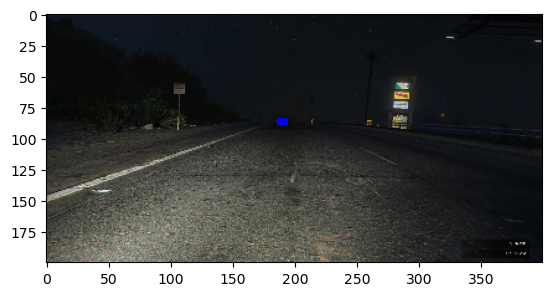

In [13]:
snapshot_sample = data[0][0]
plt.imshow(snapshot_sample.numpy().transpose(1,2,0)) # C H W --> H W C
plt.plot(bbox_x_sample, bbox_y_sample, color='b', linewidth=1)
plt.show()

## Model

In [14]:
# Custom neural network architecture
class VehicleClassifier(nn.Module):
    
    def __init__(self, num_classes, num_additional_features):
        super(VehicleClassifier, self).__init__()
        self.num_additional_features = num_additional_features

        self.features = models.resnet18(weights=True) # ResNet18 pretrained on ImageNet
        self.features = nn.Sequential(*list(self.features.children())[:-1]) # ResNet18 without last layer
        
        self.fc1 = nn.Linear(512 + num_additional_features, 256) # fully connected (dense) layer
        self.relu = nn.ReLU() # ReLU activation function
        self.dropout = nn.Dropout(0.5) # dropout layer
        self.fc2 = nn.Linear(256, num_classes) # fully connected (dense) layer

    def forward(self, x, bbox_coords=None):
        '''
        Inputs:
            x: snapshot image
            bbox_coords: bounding box coordinates as [x_min, x_max, y_min, y_max]
        '''
        x_height = x.size(2)
        x_width = x.size(3)

        x = self.features(x)
        x = x.view(x.size(0), -1) # flatten except batch dimension (N, C, H, W --> N, C*H*W)

        if bbox_coords is not None:
            bbox_coords = self.normalize_bbox(bbox_coords, x_height, x_width) # normalize bounding box coordinates
            bbox_coords = bbox_coords.view(bbox_coords.size(0), -1) # flatten except batch dimension (N, 14, 4 --> N, 14*4)
            bbox_coords = bbox_coords.to(dtype=x.dtype) # float64 tensor --> float32 tensor
            x = torch.cat((x, bbox_coords), dim=1) # concatenate flattened snapshot image and flattened bounding box coordinates
        else:
            x = torch.cat((x, torch.zeros(x.size(0), self.num_additional_features).to(device)), dim=1)
            x = x.to(dtype=x.dtype) # float64 tensor --> float32 tensor

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def normalize_bbox(self, bbox_coords, image_H, image_W):
        '''
        Inputs:
            bbox_coords: bounding box coordinates as [x_min, x_max, y_min, y_max]
        '''
        x_min = bbox_coords[:,:,0] # dim = (batch_size, vertices, 4)
        x_max = bbox_coords[:,:,1]
        y_min = bbox_coords[:,:,2]
        y_max = bbox_coords[:,:,3]

        x_min = x_min / image_W
        x_max = x_max / image_W
        y_min = y_min / image_H
        y_max = y_max / image_H

        normalized_bbox_coords = torch.stack([x_min, x_max, y_min, y_max], dim=1)
        return normalized_bbox_coords


## Training

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, Batch: 0, Loss: 1.0826
Epoch: 1 Batch: 0 Validation Accuracy: 57.82178217821782%
Epoch: 1, Batch: 60, Loss: 0.4969
Epoch: 1 Batch: 60 Validation Accuracy: 75.31353135313532%
Epoch: 1, Batch: 120, Loss: 0.7313
Epoch: 1 Batch: 120 Validation Accuracy: 79.14191419141915%
Epoch: 1, Batch: 180, Loss: 0.7164
Epoch: 1 Batch: 180 Validation Accuracy: 79.14191419141915%


 50%|█████     | 1/2 [20:57<20:57, 1257.50s/it]

Epoch: 2, Batch: 0, Loss: 0.6465
Epoch: 2 Batch: 0 Validation Accuracy: 79.60396039603961%
Epoch: 2, Batch: 60, Loss: 0.4288
Epoch: 2 Batch: 60 Validation Accuracy: 82.11221122112211%
Epoch: 2, Batch: 120, Loss: 0.3641
Epoch: 2 Batch: 120 Validation Accuracy: 80.72607260726073%
Epoch: 2, Batch: 180, Loss: 0.5962
Epoch: 2 Batch: 180 Validation Accuracy: 81.84818481848185%


100%|██████████| 2/2 [40:31<00:00, 1215.60s/it]


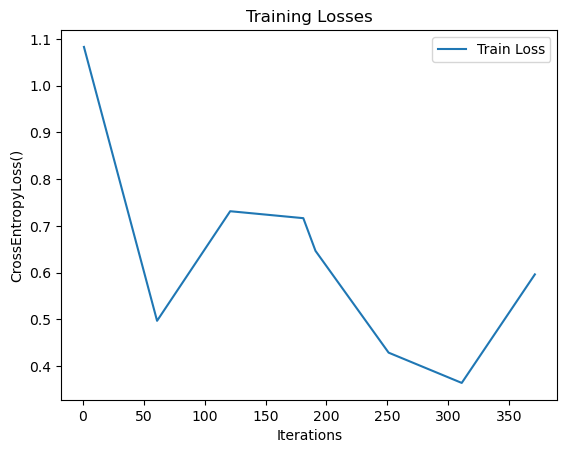

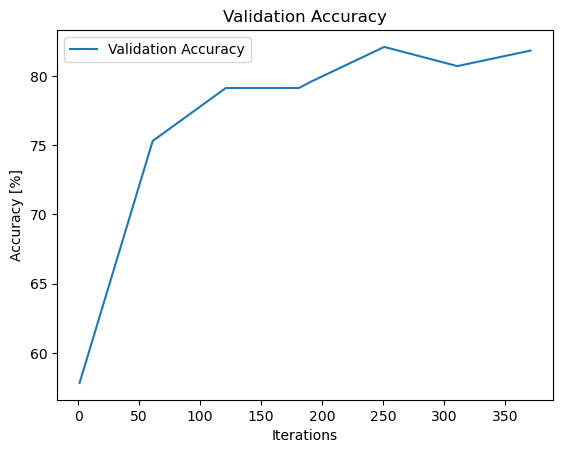

In [15]:
# HYPERPARAMETERS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_additional_features = 4*14                      # number of additional features 
                                                    # (x_min, x_max, y_min, y_max of bounding box)
num_classes = 3                                     # number of classes (vehicle labels: 0, 1, or 2)
lr = 1e-4                                           # learning rate
model = VehicleClassifier(num_classes, num_additional_features) # model
model = model.to(device)                            # move model to GPU
criterion = nn.CrossEntropyLoss()                   # loss function
optimizer = optim.Adam(model.parameters(), lr=lr)   # optimizer
num_epochs = 6                                      # number of training epochs

train_losses = []
val_acc = []
iterations = []
count = 0


# TRAINING
for epoch in tqdm(range(num_epochs)):
    model.train()

    # ITERATION
    for i, (snapshots, bbox_coords, labels) in enumerate(train_dataloader, 0):
        # INPUTS
        snapshots = snapshots.to(device)
        bbox_coords = bbox_coords.to(device)
        labels = labels.to(device)
        
        # ZERO OUT THE GRADIENTS
        optimizer.zero_grad()
        # FORWARD PASS
        outputs = model(snapshots, bbox_coords)
        # COMPUTE LOSS
        loss = criterion(outputs, labels)
        # BACKPROPAGATE
        loss.backward()
        # UPDATE WEIGHTS
        optimizer.step()

        count += 1

        if i % 60 == 0:
            # ACCUMULATE TRAINING LOSS
            print('Epoch: %d, Batch: %d, Loss: %.4f' % (epoch + 1, i, loss.item()))
        
            # VALIDATION
            model.eval()
            val_loss = 0.

            # TURN OFF GRADIENTS (b/c we're not training)
            with torch.no_grad():
                correct = 0
                total = 0

                # ITERATION
                for snapshots, bbox_coords, labels in val_dataloader:
                    # INPUTS
                    snapshots = snapshots.to(device)
                    bbox_coords = bbox_coords.to(device)
                    labels = labels.to(device)
                    # FORWARD PASS
                    outputs = model(snapshots, bbox_coords)
                    # PREDICT
                    _, pred = torch.max(outputs.data, 1)
                    # COUNT TOTAL AND CORRECT
                    total += labels.size(0)
                    correct += (pred == labels).sum().item()
                
                # COMPUTE ACCURACY
                accuracy = 100 * correct / total # average accuracy [%]
                print(f'Epoch: {epoch+1} Batch: {i} Validation Accuracy: {accuracy}%')

                # ACCUMULATE TRAIN LOSS & VALIDATION ACCURACY
                train_losses.append(loss.data.item())
                iterations.append(count)
                val_acc.append(accuracy)

    # SAVE MODEL
    # torch.save(model.state_dict(), f"model_epoch{epoch+1}.pth")


# Plot training loss
plt.plot(iterations, train_losses, label="Train Loss")
plt.xlabel("Iterations")
plt.ylabel(f"{criterion}")
plt.title("Training Losses")
plt.legend()
plt.show()
# Plot validation accuracy
plt.plot(iterations, val_acc, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy [%]")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

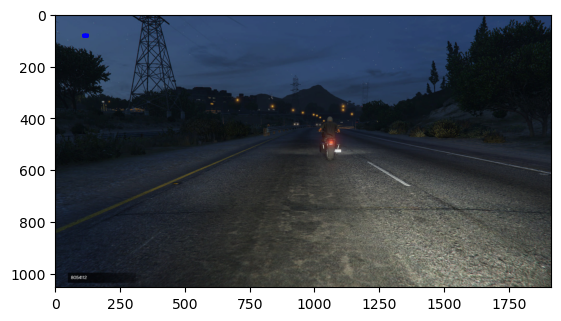

In [20]:
# yy = bbox_coords.cpu()
# xx = snapshots.cpu()
# xx = xx[0]
# yy = yy[0]
# yy1 = yy[:,[0,1]].flatten() # x_min, x_max
# yy2 = yy[:,[2,3]].flatten() # y_min, y_max
# plt.imshow(xx.numpy().transpose(1,2,0)) # C H W --> H W C
# plt.plot(yy1, yy2, color='b', linewidth=1)
# plt.show()

## Evaluation

In [28]:
with open('prediction_results_resnet_extra_features.csv', 'w', newline='') as f:
    # Create a CSV writer object
    csv_writer = csv.writer(f)
    
    # Write header line
    csv_writer.writerow(["guid/image","label"])

    with torch.no_grad():
        for snapshots, paths in tqdm(test_dataloader):
            # INPUTS
            snapshots = snapshots.to(device)
            # FORWARD PASS
            outputs = model(snapshots)
            # PREDICT
            _, pred = torch.max(outputs.data, 1)
            # WRITE TO FILE
            for i in range(len(paths)):  # loop through batches
                csv_writer.writerow([paths[i], pred.item()])

100%|██████████| 2631/2631 [10:01<00:00,  4.37it/s]
